<a href="https://colab.research.google.com/github/Aisha-Hagar/Machine_Learning/blob/main/Network_Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

## **Install and import required packages**

In [ ]:
#!pip install imbalanced-learn

In [ ]:
!pip install kafka-python

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from numpy import nan, inf
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [ ]:
import time

# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer

## **Load the data**

In [ ]:
cicids_static_data = pd.read_csv("cicids_static_data.csv") 
print(cicids_static_data.info())
print("Labels are: ",cicids_static_data.Label.unique())
print('Number of samples in each class = \n', cicids_static_data.Label.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25191 entries, 0 to 25190
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             25191 non-null  int64  
 1    Flow Duration                25191 non-null  int64  
 2    Total Fwd Packets            25191 non-null  int64  
 3    Total Backward Packets       25191 non-null  int64  
 4   Total Length of Fwd Packets   25191 non-null  int64  
 5    Total Length of Bwd Packets  25191 non-null  int64  
 6    Fwd Packet Length Max        25191 non-null  int64  
 7    Fwd Packet Length Min        25191 non-null  int64  
 8    Fwd Packet Length Mean       25191 non-null  float64
 9    Fwd Packet Length Std        25191 non-null  float64
 10  Bwd Packet Length Max         25191 non-null  int64  
 11   Bwd Packet Length Min        25191 non-null  int64  
 12   Bwd Packet Length Mean       25191 non-null  float64
 13   

Seperate the features and the labels.

In [ ]:
X = cicids_static_data.drop(columns=['Label'])
y = cicids_static_data['Label']

Remove the extra spaces in the column names. 

In [ ]:
X.columns = X.columns.str.strip()

# **Static Solution**

Split the data to train and test with ratio 7:3.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## **Data Preprocessing**

In [ ]:
X_train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,17633.000000,1.763300e+04,17633.000000,17633.000000,1.763300e+04,1.763300e+04,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,1.762900e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,17633.000000,17633.0,17633.000000,17633.0,1.763300e+04,1.763300e+04,1.763300e+04,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,1.763300e+04,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,1.763300e+04,17633.0,17633.0,17633.0,17633.0,17633.0,17633.0,17633.000000,1.763300e+04,17633.000000,1.763300e+04,17633.000000,17633.000000,17633.000000,17633.000000,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04
mean,8705.995747,1.310048e+07,16.957636,20.360744,5.949000e+02,3.800008e+04,222.580899,20.773890,62.305683,72.485096,620.934158,45.689389,229.406312,225.888901,inf,inf,1.135653e+06,2.295641e+06,6.863174e+06,1.508384e+05,1.278254e+07,2.347631e+06,2.205986e+06,6.705550e+06,1.195861e+06,1.016942e+07,1.882210e+06,1.238837e+06,4.301160e+06,1.125566e+06,0.048375,0.0,0.000113,0.0,3.793700e+02,4.421237e+02,5.989904e+04,7097.872156,18.295582,711.270062,138.774953,218.703207,2.921620e+05,0.025237,0.048375,0.000113,0.283219,0.299552,0.106278,0.000113,0.000113,0.688425,156.156348,62.305683,229.406312,3.793700e+02,0.0,0.0,0.0,0.0,0.0,0.0,16.957636,5.949000e+02,20.360744,3.800008e+04,7022.653717,2385.866841,13.763455,25.928883,7.812982e+04,4.529789e+04,1.604343e+05,5.298457e+04,6.045257e+06,3.678493e+05,6.319823e+06,5.743272e+06
std,19008.162877,3.202971e+07,1455.331023,1933.970870,9.099468e+03,4.336241e+06,740.494378,64.243583,190.984514,289.248721,1474.711334,71.309366,469.323943,622.753348,NaN,NaN,4.384910e+06,7.241538e+06,2.018874e+07,2.706035e+06,3.193001e+07,9.852507e+06,7.430390e+06,2.023687e+07,9.316743e+06,2.905637e+07,9.446894e+06,5.242753e+06,1.561931e+07,9.052886e+06,0.214564,0.0,0.010650,0.0,2.967790e+04,3.868059e+04,2.322762e+05,39665.805517,27.396447,1599.482380,251.253294,494.318815,1.239798e+06,0.156848,0.214564,0.010650,0.450575,0.458075,0.308202,0.010650,0.010650,0.660675,271.509994,190.984514,469.323943,2.967790e+04,0.0,0.0,0.0,0.0,0.0,0.0,1455.331023,9.099468e+03,1933.970870,4.336241e+06,14651.307530,9359.112789,1409.393811,6.447377,9.062427e+05,3.973834e+05,1.284668e+06,8.631337e+05,1.930875e+07,3.805458e+06,1.996591e+07,1.903648e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,

### **Feature extraction**

Get columns with constant value.

In [ ]:
const = list((X_train.columns[X.nunique() <= 1]).values)
print(const)

['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


Check if columns contain null or infinite values.

In [ ]:
print(X_train.isnull().values.any())
print(X_train.isin([np.inf, -np.inf]).values.any())

True
True


In [ ]:
X_train.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

Drop columns with constant value as they won't have an effect on the model's prediction.

In [ ]:
X_train = X_train.drop(columns=const)

Get highly correlated features and drop them because they are considered redundant features.

Reference: https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/

In [ ]:
correlated_features = set()
correlation_matrix = X_train.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print('Number of correlated features = ', len(correlated_features))
print(correlated_features)
X_train.drop(labels=correlated_features, axis=1, inplace=True)

Number of correlated features =  41
{'Bwd IAT Mean', 'Fwd Packets/s', 'SYN Flag Count', 'Average Packet Size', 'Avg Bwd Segment Size', 'Fwd Packet Length Mean', 'Fwd IAT Min', 'Fwd Header Length', 'Flow IAT Max', 'Fwd Header Length.1', 'Bwd IAT Min', 'Bwd Header Length', 'Total Length of Bwd Packets', 'Packet Length Variance', 'Idle Mean', 'Fwd IAT Mean', 'Idle Min', 'Fwd Packet Length Std', 'Fwd IAT Std', 'Packet Length Mean', 'Max Packet Length', 'ECE Flag Count', 'CWE Flag Count', 'Active Max', 'Subflow Bwd Packets', 'Subflow Fwd Packets', 'act_data_pkt_fwd', 'Total Backward Packets', 'Idle Max', 'Bwd Packet Length Std', 'Avg Fwd Segment Size', 'Active Mean', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Total Length of Fwd Packets', 'Bwd Packet Length Mean', 'Fwd IAT Total', 'Active Min', 'Packet Length Std', 'Fwd IAT Max', 'Bwd IAT Total'}


### **Impute missing values**

Convert infinite values to nan and impute null values using sklearn's simple imputer with median strategy.

In [ ]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
imp_med.fit(X_train)
X_train = pd.DataFrame(imp_med.transform(X_train), columns = X_train.columns)

In [ ]:
X_train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Min,Bwd IAT Std,Bwd IAT Max,Fwd PSH Flags,Fwd URG Flags,Bwd Packets/s,Min Packet Length,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Std,Idle Std
count,17633.000000,1.763300e+04,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,1.763300e+04,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,17633.000000,1.763300e+04,1.763300e+04
mean,8705.995747,1.310048e+07,16.957636,222.580899,20.773890,620.934158,45.689389,1.647581e+06,6.688354e+04,1.135653e+06,2.295641e+06,1.508384e+05,1.238837e+06,4.301160e+06,0.048375,0.000113,7097.872156,18.295582,0.025237,0.000113,0.283219,0.299552,0.106278,0.688425,7022.653717,2385.866841,25.928883,4.529789e+04,3.678493e+05
std,19008.162877,3.202971e+07,1455.331023,740.494378,64.243583,1474.711334,71.309366,2.741968e+07,2.409128e+05,4.384910e+06,7.241538e+06,2.706035e+06,5.242753e+06,1.561931e+07,0.214564,0.010650,39665.805517,27.396447,0.156848,0.010650,0.450575,0.458075,0.308202,0.660675,14651.307530,9359.112789,6.447377,3.973834e+05,3.805458e+06
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07,-2.000000e+06,-1.000000e+00,0.000000e+00,-1.200000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000e+00,0.000000e+00
25%,53.000000,1.660000e+02,2.000000,6.000000,0.000000,6.000000,0.000000,1.180709e+02,6.454727e+00,6.500000e+01,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.179215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,20.000000,0.000000e+00,0.000000e+00
50%,80.000000,3.131000e+04,2.000000,38.000000,6.000000,83.000000,6.000000,4.720129e+03,1.112013e+02,1.133133e+04,1.212436e+02,4.000000e+00,0.000000e+00,3.000000e+00,0.000000,0.000000,20.984421,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,235.000000,-1.000000,20.000000,0.000000e+00,0.000000e+00
75%,443.000000,1.459341e+06,4.000000,76.000000,38.000000,212.000000,86.000000,1.904762e+05,2.234637e+04,2.091720e+05,2.644310e+05,7.200000e+01,8.738004e+03,4.386500e+04,0.000000,0.000000,6578.947368,38.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,8192.000000,235.000000,32.000000,0.000000e+00,0.000000e+00
max,65464.000000,1.199998e+08,193200.000000,11632.000000,1983.000000,11680.000000,1460.000000,2.071000e+09,3.000000e+06,9.630000e+07,8.190000e+07,9.630000e+07,8.260000e+07,1.200000e+08,1.000000,1.000000,1000000.000000,1306.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,65535.000000,65535.000000,60.000000,2.529324e+07,6.270000e+07


### **Oversampling**

The dataset is highly imbalanced, oversampling is applied using SMOTE to increase the number of samples of "ATTACK" class.

Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('Classes distribution after oversampling = ',counter)

Classes distribution after oversampling =  Counter({'BENIGN': 15923, 'ATTACK': 15923})


## **Training phase**

The model used is Adaboost classifier with 100 estimators.

In [ ]:
ada_clf = AdaBoostClassifier(n_estimators = 100, random_state=0)

              precision    recall  f1-score   support

      ATTACK       0.99      1.00      0.99     15923
      BENIGN       1.00      0.99      0.99     15923

    accuracy                           0.99     31846
   macro avg       0.99      0.99      0.99     31846
weighted avg       0.99      0.99      0.99     31846



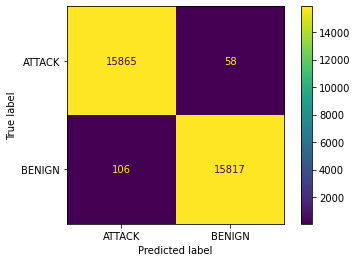

In [ ]:
ada_clf.fit(X_train, y_train)
y_train_pred = ada_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred, labels=ada_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_clf.classes_)
disp.plot()
plt.show()

## **Testing and Evaluation phases**

1. Drop the columns determined in the preprocessing phase.

2. Impute missing values using median strategy.

3. Predict the test dataset.

4. Print the classification report.

5. Plot the confusion matrix.

              precision    recall  f1-score   support

      ATTACK       0.93      0.99      0.96       737
      BENIGN       1.00      0.99      1.00      6821

    accuracy                           0.99      7558
   macro avg       0.96      0.99      0.98      7558
weighted avg       0.99      0.99      0.99      7558



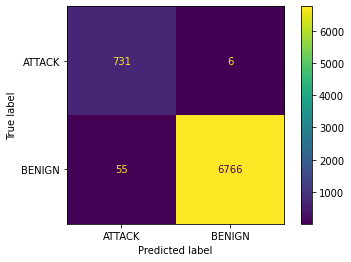

In [ ]:
X_test = X_test.drop(columns=const)
X_test.drop(labels=correlated_features, axis=1, inplace=True)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = pd.DataFrame(imp_med.transform(X_test), columns = X_test.columns)
y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=ada_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_clf.classes_)
disp.plot()
plt.show()

# **Dynamic Solution**

## **Initial Data Preprocessing**

For the dynamic solution, initial data preprocessing is done based on the static solution. 
1. Drop the columns determind in the static solution's data preprocessing phase.

2. Impute missing values using median strategy.

In [ ]:
X = X.drop(columns=const)
X.drop(labels=correlated_features, axis=1, inplace=True)
X = X.replace([np.inf, -np.inf], np.nan)
imp_med.fit(X)
X = pd.DataFrame(imp_med.transform(X), columns = X.columns)

## **Initial Training**

The model used is Adaboost classifier with 100 estimators. Initially, the model is trained on the static dataset. 

              precision    recall  f1-score   support

      ATTACK       0.99      0.98      0.98      2447
      BENIGN       1.00      1.00      1.00     22744

    accuracy                           1.00     25191
   macro avg       0.99      0.99      0.99     25191
weighted avg       1.00      1.00      1.00     25191



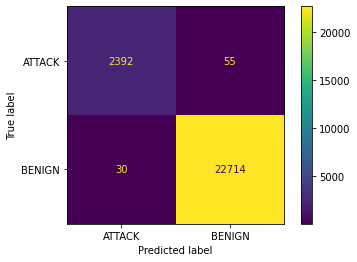

In [ ]:
ada_clf_dyn = AdaBoostClassifier(n_estimators = 100, random_state=0)
ada_clf_dyn.fit(X, y)
y_all_pred = ada_clf_dyn.predict(X)
print(classification_report(y, y_all_pred))
cm = confusion_matrix(y, y_all_pred, labels=ada_clf_dyn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_clf_dyn.classes_)
disp.plot()
plt.show()

## **Updated Training and Testing**

1. Data preprocessing is applied to each received packet.

2. The preprocessed packet is then passed to the model to predict the label.

3. In each iteration, the predictions are stored to be later used for evaluation. 

4. After every 1000 packets, the train data will be updated by removing the first 1000 rows and adding the newly recieved 1000 packets.

5. The number of iterations is 100, which means that, in total, 100000 packets are recieved.

In [ ]:
X_update = X
y_update = y
f1_scores = []
acc_scores = []
f1_scores_dyn = []
acc_scores_dyn = []
Att = []
Ben = []
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task1',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

for k in range(100):  

  # Data Stream flowing in.
  i = 0
  X_new = pd.DataFrame(columns = X.columns)
  y_new = pd.Series([], dtype=str)
  y_pred = []
  y_pred_dyn = []
  imp_med.fit(X_update)
  print(f"Iteration {k}:")
  Att.append(y_update.value_counts().ATTACK)
  Ben.append(y_update.value_counts().BENIGN)
  for message in consumer:
      print(f"Consuming the {i+1}th data packet!")
      
      data_packet = message.value
      #print(data_packet)
      packet_dict = eval(data_packet.decode("UTF-8"))
      packet_df = pd.DataFrame(packet_dict, index=[0,])
      x = packet_df.drop(columns=['Label'])
      yp = packet_df['Label']
      x = x.drop(columns=const)
      x.drop(labels=correlated_features, axis=1, inplace=True)
      x = x.replace([np.inf, -np.inf], np.nan)
      x = pd.DataFrame(imp_med.transform(x), columns = x.columns)
      X_new = X_new.append(x, ignore_index=True)
      y_new = y_new.append(yp, ignore_index=True)
      packet_pred = ada_clf.predict(x)
      packet_pred_dyn = ada_clf_dyn.predict(x)
      #print(f'Static model predicted label of packet {i+1} is {packet_pred}')
      #print(f'Dynamic model predicted label of packet {i+1} is {packet_pred_dyn}')
      #print(f'True label of packet {i+1} is {yp.values}')
      y_pred = np.append(y_pred, packet_pred)  
      y_pred_dyn = np.append(y_pred_dyn, packet_pred_dyn)      

      i+=1
      if i == 1000:
          break
  f1_scores = np.append(f1_scores, f1_score(y_new, y_pred, pos_label='ATTACK'))
  acc_scores = np.append(acc_scores, accuracy_score(y_new, y_pred))
  f1_scores_dyn = np.append(f1_scores_dyn, f1_score(y_new, y_pred_dyn, pos_label='ATTACK'))
  acc_scores_dyn = np.append(acc_scores_dyn, accuracy_score(y_new, y_pred_dyn))
  X_update = X_update.iloc[1000:,] 
  X_update = X_update.append(X_new, ignore_index=True)
  y_update = y_update.iloc[1000:,]
  y_update = y_update.append(y_new, ignore_index=True)
  
  ada_clf_dyn.fit(X_update, y_update)


Streaming output truncated to the last 5000 lines.
Consuming the 5th data packet!
Consuming the 6th data packet!
Consuming the 7th data packet!
Consuming the 8th data packet!
Consuming the 9th data packet!
Consuming the 10th data packet!
Consuming the 11th data packet!
Consuming the 12th data packet!
Consuming the 13th data packet!
Consuming the 14th data packet!
Consuming the 15th data packet!
Consuming the 16th data packet!
Consuming the 17th data packet!
Consuming the 18th data packet!
Consuming the 19th data packet!
Consuming the 20th data packet!
Consuming the 21th data packet!
Consuming the 22th data packet!
Consuming the 23th data packet!
Consuming the 24th data packet!
Consuming the 25th data packet!
Consuming the 26th data packet!
Consuming the 27th data packet!
Consuming the 28th data packet!
Consuming the 29th data packet!
Consuming the 30th data packet!
Consuming the 31th data packet!
Consuming the 32th data packet!
Consuming the 33th data packet!
Consuming the 34th data pa

## **Evaluation**

Evalute the model's performance in each iteration. During each iteration, 1000 data packets are tested. 

Plot f1 score for each iteration.

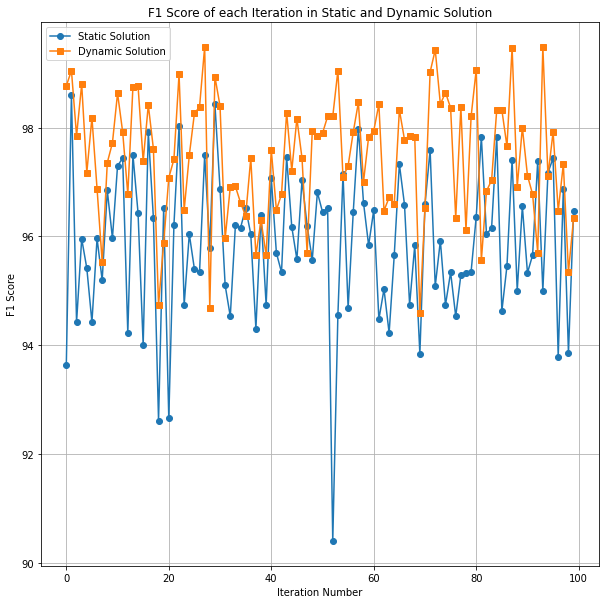

In [ ]:
plt.figure(figsize=(10, 10))
x_ax = range(100)
plt.plot(f1_scores *100, marker = 'o', label = "Static Solution")
plt.plot(f1_scores_dyn*100, marker = 's', label = "Dynamic Solution")
plt.xlabel("Iteration Number")
plt.ylabel("F1 Score")
plt.title('F1 Score of each Iteration in Static and Dynamic Solution')
plt.grid()
plt.legend()
plt.show()

Plot accuracy of each iteration

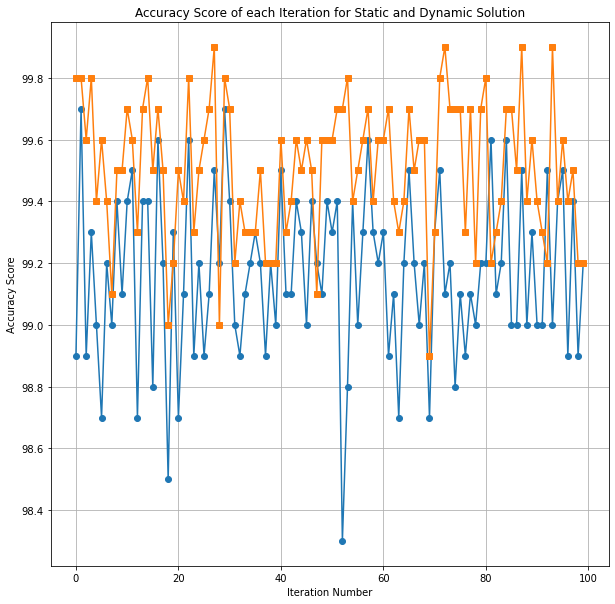

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(range(100), acc_scores*100, marker = 'o')
plt.plot(range(100), acc_scores_dyn*100, marker = 's')
plt.xlabel("Iteration Number")
plt.ylabel("Accuracy Score")
plt.title('Accuracy Score of each Iteration for Static and Dynamic Solution')
plt.grid()
plt.show()

Plot the labels distribution in the updated train dataset of each iteration.

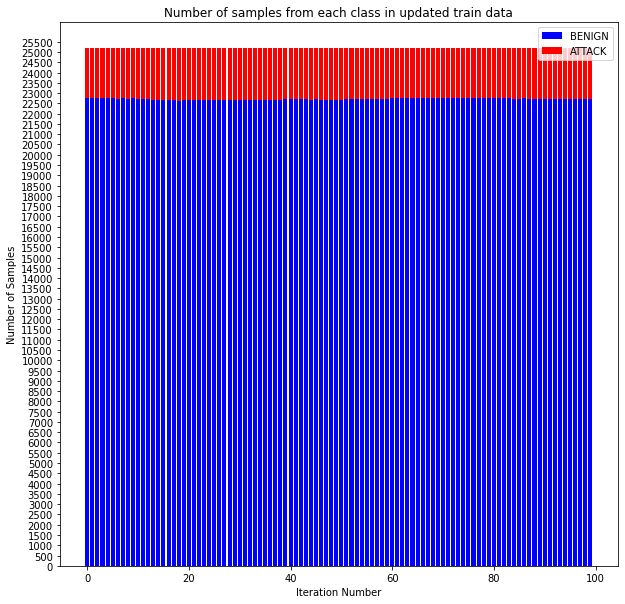

In [ ]:
plt.figure(figsize=(10, 10))
X_axis = np.arange(100)
#plt.xticks(X_axis)
plt.yticks(np.arange(0 , max(Ben)+max(Att)+500, 500))
plt.bar(X_axis, Ben, color='b')
plt.bar(X_axis, Att, bottom=Ben, color='r')
plt.xlabel("Iteration Number")
plt.ylabel("Number of Samples")
plt.title('Number of samples from each class in updated train data')
plt.legend(['BENIGN', 'ATTACK'])
plt.show()